<a href="https://colab.research.google.com/github/amkutuzova/clinic/blob/main/code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install yake

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.2/60.2 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 356.9/356.9 kB 18.5 MB/s eta 0:00:00


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/499 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/943 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/711M [00:00<?, ?B/s]

Installing mystem to /root/.local/bin/mystem from http://download.cdn.yandex.net/mystem/mystem-3.1-linux-64bit.tar.gz
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


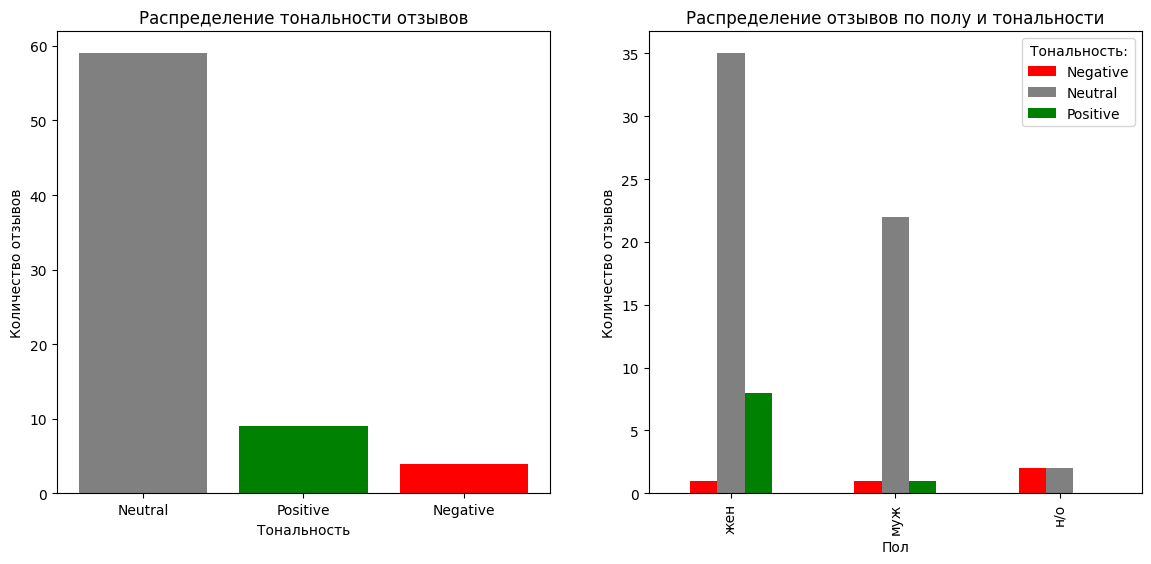

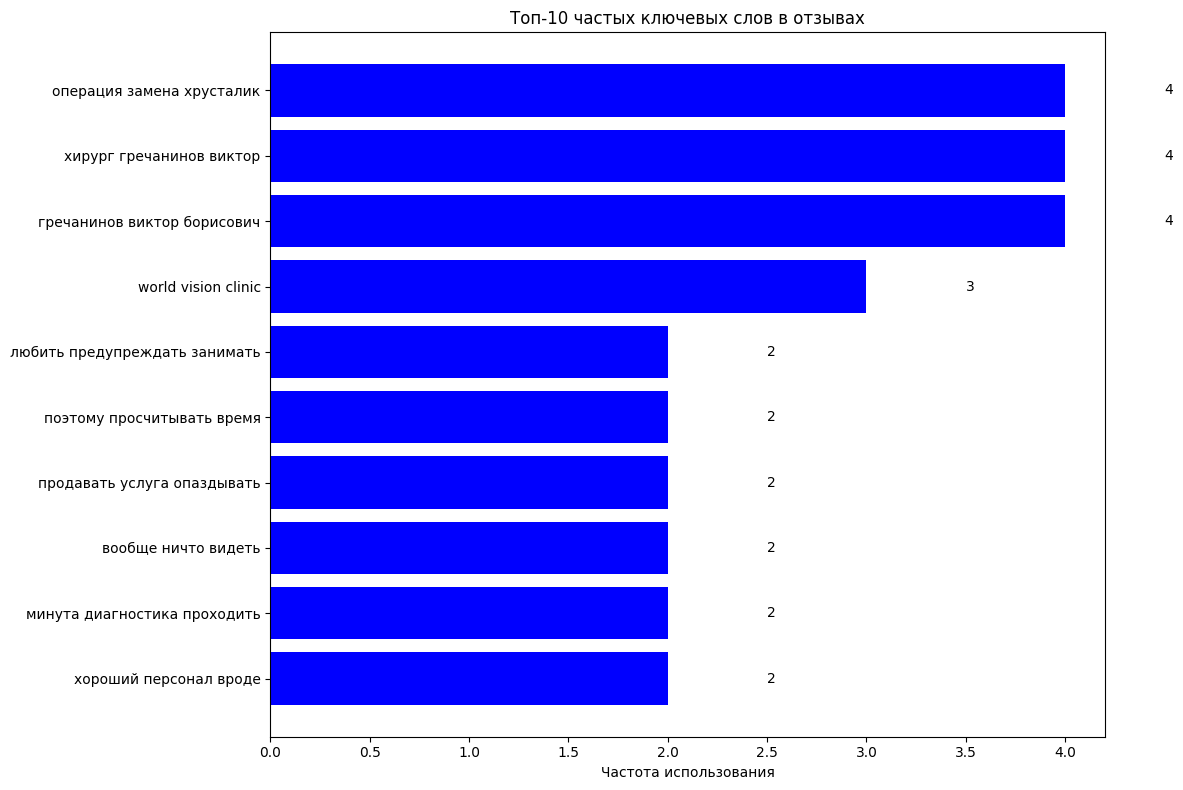

Результаты сохранены в 'Обработанные_отзывы.xlsx'


2

In [ ]:
from transformers import AutoModelForSequenceClassification
from transformers import BertTokenizerFast
from nltk.corpus import stopwords
from pymystem3 import Mystem
import matplotlib.pyplot as plt
import torch
import nltk
import string
import yake
import numpy as np
import pandas as pd

nltk.download("stopwords")


#предобработка текста, нормализуем текст
def normalize_text(file_name):
    mystem = Mystem()
    russian_stopwords = stopwords.words("russian")
    punctuation = string.punctuation #знаки препинания

    tokens = mystem.lemmatize(file_name.lower()) #нижний регистр

    clean_tokens = [] #токенизация и стоп-слова
    for token in tokens:
        if token not in russian_stopwords and token.isalnum():
            clean_tokens.append(token)
    text = " ".join(clean_tokens)
    return text


#ключевые слова и оценка уверенности модели для каждого предобработанного отзыва
def find_keywords(file_name):
    kw_extractor = yake.KeywordExtractor() #инициализация экстрактора yake
    keywords = kw_extractor.extract_keywords(file_name)
    return [(kw[0], float(kw[1])) for kw in keywords]


#загрузка модели для анализа тональности
tokenizer = BertTokenizerFast.from_pretrained('blanchefort/rubert-base-cased-sentiment')
model = AutoModelForSequenceClassification.from_pretrained('blanchefort/rubert-base-cased-sentiment', return_dict=True)

#анализ тональности с помощью предобученной модели
def analyze_sentiment(file_name):
    inputs = tokenizer(file_name, padding=True, truncation=True, return_tensors='pt')
    outputs = model(**inputs)
    predicted = torch.nn.functional.softmax(outputs.logits, dim=1)
    predicted = torch.argmax(predicted, dim=1).item()
    return predicted

df = pd.read_excel('/content/Исходные данные. ЦК.xlsx')

#заменяем пустые строковые значения
for col in df.columns:
    if df[col].dtype == 'object':  #только для строковых столбцов
        df[col] = df[col].fillna('н/о')


df['normalized_text'] = df['Тело'].apply(normalize_text) #нормализация
df['key_words'] = df['normalized_text'].apply(find_keywords) #извлечение ключей
df['sentiment'] = df['Тело'].apply(analyze_sentiment) #анализ тональности


plt.figure(figsize=(14, 6)) #визуализация результатов


#график 1. Распределение тональности
#преобразование тональности в категориальные метки
plt.subplot(1, 2, 1)    #1 строка, 2 столбца, 1я позиция
sentiment_labels = {0: "Negative", 1: "Neutral", 2: "Positive"}
df['sentiment_label'] = df['sentiment'].map(sentiment_labels)
sentiment_counts = df['sentiment_label'].value_counts()

#сопоставление цветов по категориям
colors = []
for label in sentiment_counts.index:
    if label == "Negative":
        colors.append('red')
    if label == "Neutral":
        colors.append('gray')
    if label == "Positive":
        colors.append('green')

plt.bar(sentiment_counts.index, sentiment_counts.values, color=colors)
plt.xlabel('Тональность')
plt.ylabel('Количество отзывов')
plt.title('Распределение тональности отзывов')


#график 2. Распределение отзывов по полу и тональности
plt.subplot(1, 2, 2)  #1 строка, 2 столбца, 2я позиция
gender_sentiment = df.groupby(['Пол', 'sentiment_label']).size().unstack() #группируем по полу и тональности
gender_sentiment = gender_sentiment[['Negative', 'Neutral', 'Positive']]   #упорядочиваем столбцы

gender_sentiment.plot(kind='bar', color=['red', 'gray', 'green'], ax=plt.gca()) #диаграмма с накоплением

plt.xlabel('Пол')
plt.ylabel('Количество отзывов')
plt.title('Распределение отзывов по полу и тональности')
plt.legend(title='Тональность:')


#график 3. Топ10 ключевых слов
#собираем в 1 список все ключевые слова
all_keywords = []
for keyword_list in df['key_words']:
    for keyword, score in keyword_list:
        all_keywords.append(keyword.lower())  #нижний регистр

#считаем частоту слов со словарем
word_counts = {}
for word in all_keywords:
    if word in word_counts:
        word_counts[word] += 1
    else:
        word_counts[word] = 1

#сортируем по частоте
sorted_words = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)
top_words = sorted_words[:10]

#создаем данные для гарфика
words = [word for word, count in top_words]
counts = [count for word, count in top_words]

#горизонтальная столбчатая диаграмма
plt.figure(figsize=(12, 8))
y_pos = np.arange(len(words))

plt.barh(y_pos, counts, align='center', color='blue')
plt.yticks(y_pos, words)
plt.xlabel('Частота использования')
plt.title('Топ-10 частых ключевых слов в отзывах')
plt.gca().invert_yaxis()  #по частоте сверху вниз

#значения на столбцы
for i, n in enumerate(counts):
    plt.text(n + 0.5, i, str(n), color='black', va='center')


plt.tight_layout()
plt.show()


#сохраняем результаты
df.to_excel('Обработанные_отзывы.xlsx')
print("Результаты сохранены в 'Обработанные_отзывы.xlsx'")


normalize_text('/content/Исходные данные. ЦК.xlsx')
find_keywords('/content/Исходные данные. ЦК.xlsx')
analyze_sentiment('/content/Исходные данные. ЦК.xlsx')